In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

In [2]:
# 데이터를 np array로 training에서 사람 이미지 한장과 영역 이미지 한장을 불러오는 코드를 작성해주세요. (x, y로 변수 대입)
import glob
import imageio

x = imageio.imread('/home/aiffel/flip_cv_nlp/dataset/training/00001.png')
y = imageio.imread('/home/aiffel/flip_cv_nlp/dataset/training/00001_matte.png')

x.shape, y.shape

((800, 600, 3), (800, 600))

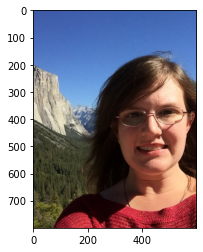

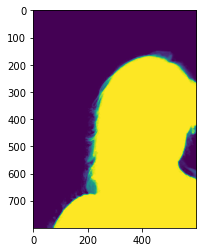

In [3]:
import matplotlib.pyplot as plt
plt.imshow(x)
plt.show()
plt.imshow(y)
plt.show()


In [4]:
x.shape,y.shape

((800, 600, 3), (800, 600))

In [5]:
# x와 y를 각각 (800, 600, 3) -> (100, 75, 3), (800, 600) -> (100, 75)로 줄이고 plt에서 확인하는 코드를 작성하세요.
from skimage.transform import resize
x = resize(x,(100,75,3))
y = resize(y,(100,75))
x.shape, y.shape

((100, 75, 3), (100, 75))

In [6]:
# pfcn_small.npz에서 train_images, test_images, train_mattes, test_mattes를 np array로 로드하세요.
pfcn_small = np.load('/home/aiffel/flip_cv_nlp/pfcn_small.npz')

In [7]:
train_images = pfcn_small['train_images']
train_mattes = pfcn_small['train_mattes']
test_images = pfcn_small['test_images']
test_mattes = pfcn_small['test_mattes']

In [8]:
# dtype을 이용하여 이미지의 np array type을 확인해보세요.
train_images.dtype, train_mattes.dtype

(dtype('float64'), dtype('float64'))

In [9]:
# 전처리
# train/test 전체 데이터에서 각 images, mattes의 min, max를 출력하는 코드를 작성하세요.
train_images.max(), train_mattes.max()
train_images.min(), train_mattes.min()

(0.0, 0.0)

In [10]:
# (배치, 100, 75,3)의 흑백 shape을 (배치, 100, 75, 1)의 흑백 shape의 영역으로 축소하는 코드를 추가하세요.
from skimage import color
from skimage.color import rgb2gray
x = rgb2gray(x)

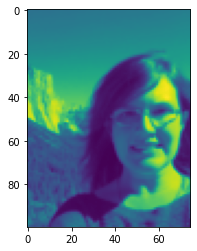

In [11]:
plt.imshow(x)
plt.show()

In [12]:
train_mattes = np.array([color.rgb2gray(img).reshape((100,75,1)) for img in train_mattes])
test_mattes = np.array([color.rgb2gray(img).reshape((100,75,1)) for img in test_mattes])
train_mattes.shape, test_mattes.shape

((1700, 100, 75, 1), (300, 100, 75, 1))

In [13]:
# (배치, 100, 75, 3)인 train_images에서 (5, 100, 75, 3)을 획득하는 코드를 작성하세요.
train_images[:5].shape

(5, 100, 75, 3)

In [14]:
train_images[:5].transpose([1,0,2,3]).reshape((100,-2,3)).shape

(100, 375, 3)

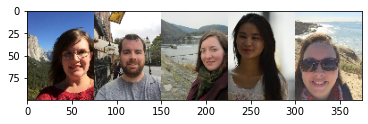

In [15]:
# 해당 기능을 이용해서 (100, 375, 3)을 작성하는 코드를 작성해보세요.
plt.imshow(train_images[:5].transpose([1,0,2,3]).reshape((100,-2,3)))
plt.show()

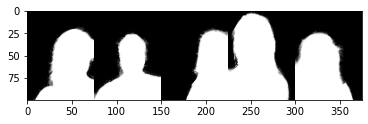

In [16]:
plt.imshow(train_mattes[:5].transpose([1,0,2,3]).reshape((100,-2)), cmap='gray')
plt.show()

In [17]:
# modeling
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, UpSampling2D, Flatten, Reshape
from keras.models import Model

def ae_like():
    inputs = Input((100,75,3))
    x = Conv2D(32,3,2,activation='relu',padding='same')(inputs)
    x = Conv2D(64,3,2,activation='relu',padding='same')(x)
    x = Conv2D(128,3,2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(10)(x)
    
    x = Dense((128*13*10))(x)
    x = Reshape((13,10,128))(x)
    
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(128,(2,2),(1,1),activation='relu',padding='valid')(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(64,(1,1),(1,1),activation='relu',padding='valid')(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(32,(1,2),(1,1),activation='relu',padding='valid')(x)
    x = Conv2D(1,(1,1),(1,1),activation='relu',padding='valid')(x)
    
    model = Model(inputs,x)
    
    
    return model

model = ae_like()
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 75, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 38, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 19, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 10, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 16640)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                166410    
_________________________________________________________________
dense_1 (Dense)              (None, 16640)             183040

In [18]:
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [19]:
hist = model.fit(train_images,train_mattes, validation_split=0.2, epochs=25)

Epoch 1/25
43/43 [==============================] - 35s 815ms/step - loss: 0.2474 - accuracy: 0.6108 - val_loss: 0.1359 - val_accuracy: 0.7627
Epoch 2/25
43/43 [==============================] - 1s 20ms/step - loss: 0.1304 - accuracy: 0.7583 - val_loss: 0.1247 - val_accuracy: 0.7714
Epoch 3/25
43/43 [==============================] - 1s 20ms/step - loss: 0.1258 - accuracy: 0.7615 - val_loss: 0.1211 - val_accuracy: 0.7759
Epoch 4/25
43/43 [==============================] - 1s 20ms/step - loss: 0.1227 - accuracy: 0.7645 - val_loss: 0.1190 - val_accuracy: 0.7795
Epoch 5/25
43/43 [==============================] - 1s 20ms/step - loss: 0.1197 - accuracy: 0.7694 - val_loss: 0.1198 - val_accuracy: 0.7778
Epoch 6/25
43/43 [==============================] - 1s 20ms/step - loss: 0.1140 - accuracy: 0.7782 - val_loss: 0.1094 - val_accuracy: 0.7953
Epoch 7/25
43/43 [==============================] - 1s 20ms/step - loss: 0.0986 - accuracy: 0.8011 - val_loss: 0.0896 - val_accuracy: 0.8213
Epoch 8/25


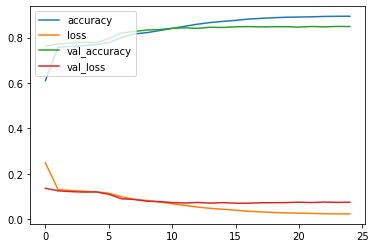

In [20]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label = "accuracy")
plt.plot(hist.history['loss'], label = "loss")
plt.plot(hist.history['val_accuracy'], label = "val_accuracy")
plt.plot(hist.history['val_loss'], label = "val_loss")
plt.legend(loc = "upper left")
plt.show()

In [21]:
# 모델에 test_mages 중 1장을 넣고 결과를 받는 코드를 작성하세요.
res = model.predict(train_images[0:1])

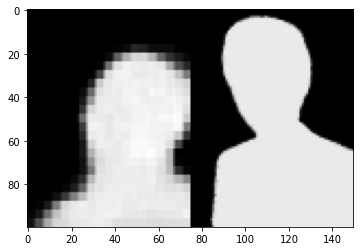

In [22]:
# res, test_mattes[1]를 width 방향으로 결합하여 (100, 75 * 3, 1) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.
# plt.imshow(np.concatenate([res[0],test_mattes[0]]).reshape((2,-1,75,1)).transpose([1,0,2,3]).reshape((100,-1)),cmap='gray')
plt.imshow(np.concatenate([res[0], test_mattes[0]]).reshape((2, -1, 75, 1)).transpose([1, 0, 2, 3]).reshape((100, -1)),cmap = "gray")
plt.show()

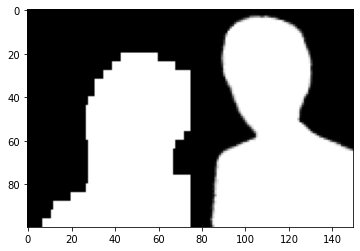

In [23]:
# res를 0.5기준으로 0,1의 값으로 이원화 시킨 뒤 출력하는 코드를 작성하세요.
plt.imshow(np.concatenate([(res[0]>0.5).astype(np.float64), test_mattes[0]]).reshape((2, -1, 75, 1)).transpose([1, 0, 2, 3]).reshape((100, -1)),cmap = "gray")

In [24]:
# 5장의 이미지를 모델에 넣고 결과를 같은 방식으로 비교하는 코드를 작성하세요
five = (model.predict(test_images[:5])>0.5).astype(np.float64)

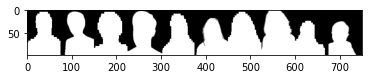

In [25]:
plt.imshow(np.concatenate([five,test_mattes[:5]],axis=2).transpose([1,0,2,3]).reshape(100,-1),cmap='gray')
plt.show()

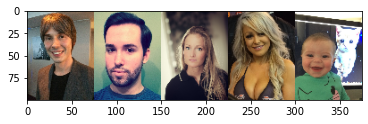

In [26]:
plt.imshow(test_images[:5].transpose((1,0,2,3)).reshape((100,-1,3)))
plt.show()

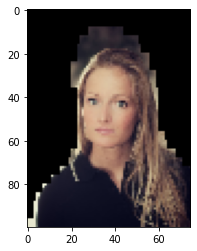

In [27]:
# 예측 이미지와 원본이미지를 곱하여 배경을 지워보세요
plt.imshow(five[2].reshape((100,75,1))*test_images[2])

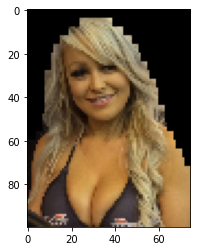

In [28]:
plt.imshow(five[3].reshape((100,75,1))*test_images[3])

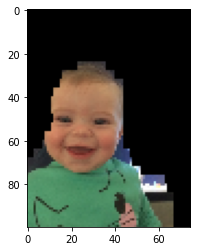

In [29]:
plt.imshow(five[4].reshape((100,75,1))*test_images[4])

# Unet

In [53]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, MaxPool2D, concatenate
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.

In [47]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

    

In [54]:
def unet_like():
    inputs = Input((100, 75, 3))
    layer1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D((2,2))(layer1)
    p1 = Dropout(0.1)(p1)
    ## maxplooling
    ## Dropout
    ## con2d
    ## maxplooling
    ## Dropout
    layer2 = conv2d_block(p1, 32)
    p2 = MaxPool2D((2,2))(layer2)
    p2 = Dropout(0.1)(p2)
    ## con2d
    ## maxplooling
    ## Dropout
    layer3 = conv2d_block(p2, 64)
    p3 = MaxPool2D((2,2))(layer3)
    p3 = Dropout(0.1)(p3)
    ## con2d
    ## maxplooling
    ## Dropout
    layer4 = conv2d_block(p3, 128)
    p4 = MaxPool2D((2,2))(layer4)
    p4 = Dropout(0.1)(p4)
    ## con2d
    layer5 = conv2d_block(p4, 256)
    ########################### Encoder End ######################
    Delayer1 = Conv2DTranspose(128, 2, 2, output_padding=(0,1))(layer5)
    Delayer1 = concatenate([Delayer1, layer4])
    Delayer1 = Dropout(0.1)(Delayer1)
    c6 = conv2d_block(Delayer1, 128)
    ## concatenate([ , ])
    ## Dropout
    ## conv2D_block
    ## Conv2DTranspose
    ## concatenate([ , ])
    ## Dropout
    ## conv2D_block
    Delayer2 = Conv2DTranspose(64, 2, 2, output_padding=(1, 0))(c6)
    Delayer2 = concatenate([Delayer2, layer3])
    Delayer2 = Dropout(0.1)(Delayer2)
    c7 = conv2d_block(Delayer2, 64)
    ## Conv2DTranspose
    ## concatenate([ , ])
    ## Dropout
    ## conv2D_block
    Delayer3 = Conv2DTranspose(32, 2, 2, output_padding=(0,1))(c7)
    Delayer3 = concatenate([Delayer3, layer2])
    Delayer3 = Dropout(0.1)(Delayer3)
    c8 = conv2d_block(Delayer3, 32)
    ## Conv2DTranspose
    ## concatenate([ , ])
    ## Dropout
    ## conv2D_block
    Delayer4 = Conv2DTranspose(16, 2, 2, output_padding=(0,1))(c8)
    Delayer4 = concatenate([Delayer4, layer1])
    Delayer4 = Dropout(0.1)(Delayer4)
    c9 = conv2d_block(Delayer4, 16)
    output = Conv2D(1, (1,1), activation="sigmoid")(c9)
    model = Model(inputs, output)
    return model

In [55]:
model=unet_like()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 100, 75, 16)  448         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 100, 75, 16)  64          conv2d_29[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 100, 75, 16)  0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

In [56]:
# 만든 모델에 loss는 mse, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [63]:
# train_images 학습시키고 25 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.
hist = model.fit(train_images, train_mattes,validation_split=0.2, epochs=25, verbose=1)

Epoch 1/25
43/43 [==============================] - 160s 4s/step - loss: 0.0119 - accuracy: 0.8989 - val_loss: 0.0092 - val_accuracy: 0.9111
Epoch 2/25
43/43 [==============================] - 2s 45ms/step - loss: 0.0120 - accuracy: 0.8989 - val_loss: 0.0087 - val_accuracy: 0.9115
Epoch 3/25
43/43 [==============================] - 2s 41ms/step - loss: 0.0111 - accuracy: 0.8998 - val_loss: 0.0106 - val_accuracy: 0.9101
Epoch 4/25
43/43 [==============================] - 2s 41ms/step - loss: 0.0105 - accuracy: 0.9004 - val_loss: 0.0087 - val_accuracy: 0.9119
Epoch 5/25
43/43 [==============================] - 2s 42ms/step - loss: 0.0095 - accuracy: 0.9013 - val_loss: 0.0094 - val_accuracy: 0.9115
Epoch 6/25
43/43 [==============================] - 2s 41ms/step - loss: 0.0093 - accuracy: 0.9014 - val_loss: 0.0084 - val_accuracy: 0.9122
Epoch 7/25
43/43 [==============================] - 2s 41ms/step - loss: 0.0095 - accuracy: 0.9011 - val_loss: 0.0112 - val_accuracy: 0.9101
Epoch 8/25
43

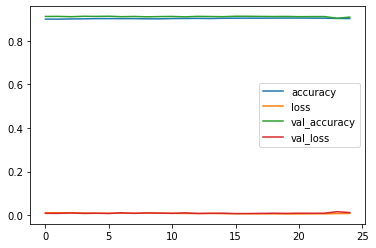

In [64]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label = "accuracy")
plt.plot(hist.history['loss'], label = "loss")
plt.plot(hist.history['val_accuracy'], label = "val_accuracy")
plt.plot(hist.history['val_loss'], label = "val_loss")
plt.legend()
plt.show()

In [65]:
result = model.predict(test_images[2:3])

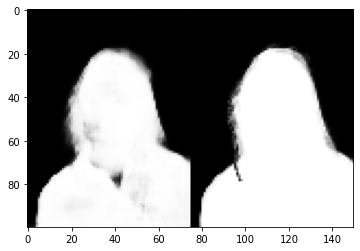

In [66]:
imgs = np.concatenate([result.reshape((100, 75, 1)), test_mattes[2]]).reshape((2, -1, 75, 1)).transpose((1,0, 2, 3)).reshape((100, -1))
plt.imshow(imgs,cmap='gray')
plt.show()

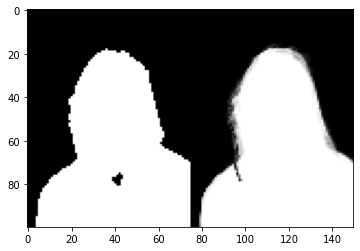

In [68]:
# result를 0.5기준으로 0,1의 값으로 이원화 시킨 뒤 문제 32처럼 출력하는 코드를 작성하세요.
plt.imshow(np.concatenate([(result>0.5).astype(np.float64).reshape((100,75,1)), test_mattes[2]]).reshape((2, -1, 75, 1)).transpose([1, 0, 2, 3]).reshape((100, -1)),cmap = "gray")

In [74]:
# 5장의 이미지를 모델에 넣고 결과를 같은 방식으로 비교하는 코드를 작성하세요
pfive = (model.predict(test_images[:5])>0.5).astype(np.float64)

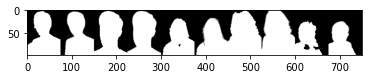

In [76]:
plt.imshow(np.concatenate([pfive,test_mattes[:5]],axis=2).transpose([1,0,2,3]).reshape(100,-1),cmap='gray')
plt.show()

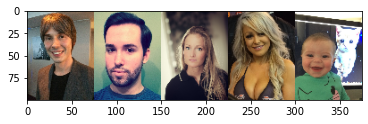

In [73]:
plt.imshow(test_images[:5].transpose((1,0,2,3)).reshape((100,-1,3)))
plt.show()

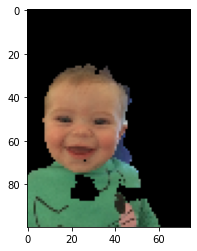

In [77]:
plt.imshow(pfive[4].reshape((100,75,1))*test_images[4])

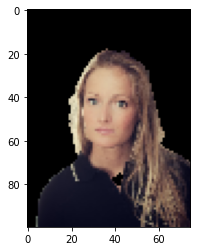

In [81]:
plt.imshow(pfive[2].reshape((100,75,1))*test_images[2])

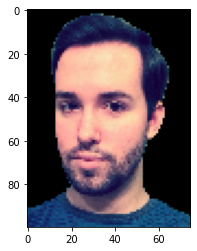

In [82]:
plt.imshow(pfive[1].reshape((100,75,1))*test_images[1])

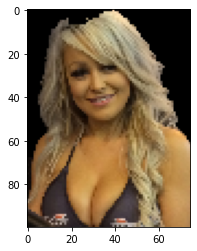

In [83]:
plt.imshow(pfive[3].reshape((100,75,1))*test_images[3])

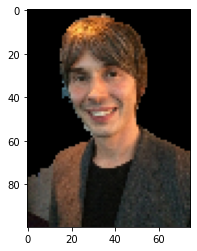

In [84]:
plt.imshow(five[0].reshape((100,75,1))*test_images[0])

In [85]:
loss ,acc = model.evaluate(test_images,test_mattes,verbose=1)
print(loss,acc)

10/10 [==============================] - 0s 12ms/step - loss: 0.0253 - accuracy: 0.8852
0.02526799961924553 0.8851893544197083


In [86]:
model.save('./AE_UNET_backgroud.h5')

In [91]:
new_model = tf.keras.models.load_model('./AE_UNET_backgroud.h5')
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 100, 75, 16)  448         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 100, 75, 16)  64          conv2d_29[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 100, 75, 16)  0           batch_normalization_20[0][0]     
____________________________________________________________________________________________